# Introduction
First iteration of Kaggle Competition "Titanic".

The goal of the competition is to predict the survival rate of the passengers, given data from the ship archives. **Thus, this is a classification problem.**

## Structure of the notebook
1. Imports
2. EDA, Feature engineering and pre-processing
4. Model selection
5. Final output


# 1. Imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
## pandas_profiling is a useful tool to do the first EDA before cleaning up the data
## https://towardsdatascience.com/speed-up-your-exploratory-data-analysis-with-pandas-profiling-88b33dc53625
from pandas_profiling import ProfileReport
# import string

# Statistics and model training
import statistics as stat
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,  cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# Visualizations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from pandas.plotting import scatter_matrix



plt.style.use('ggplot')
%matplotlib inline

# 2. EDA

## Data set dictionary
link: https://www.kaggle.com/c/titanic/data

- Survived => categorical, Yes = 1, No = 0
- pclass => class of the passenger, in particular ticket class (1st = Upper 2nd = Middle 3rd = Lower)
- sex
- age (in years) (Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5)
- sibsp => number of spouses/siblings on board (absolute count, finite)
- parch => number of parent, children on board (absolute count, finite)
- ticket => ticket id
- fare => passenger fare
- cabin number
- Embarked => port at which the passnger boarded (C = Cherbourg, Q = Queenstown, S = Southampton)


In [2]:
# load data
train_wd = pd.read_csv('titanic_train.csv')

test_wd = pd.read_csv('titanic_test.csv')

In [3]:
display(train_wd.head()); display(test_wd.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


First thing, we want to explore the training dataset to have a feeling of the data. 

In [4]:
# Define some utility functions to speed up the EDA phase

# apply func to columns for obtaining new one
def apply_to_dfs(col, new_col, func):
    '''
    given a column name, new_column name and function, it applies the custom function column-wise
    '''
    train_wd[new_col] = train_wd[col].apply(func)
    test_wd[new_col] = test_wd[col].apply(func)

# fill NaNs with mean
def fill_mean(feat):
    '''
    Replace NaN values with the mean of the column, in place
    '''
    train_wd[feat].fillna(train_wd[feat].mean(), inplace=True)
    test_wd[feat].fillna(test_wd[feat].mean(), inplace=True)
    
# drop column
def drop(col, only_train=False):
    '''
    select column to drop from either the training set or both sets
    '''
    train.drop(columns=[col], inplace=True)
    if not only_train:
        test.drop(columns=[col], inplace=True)

# perform One Hot Encoding on Categorical Variables
# perform OHE
def make_dummies(feat):
    '''
    Manual One Hot Encoding for categorical variables on train and test set
    '''
    
    global train
    global test
    
    dum_train = pd.get_dummies(train[feat], prefix=feat, drop_first=True)
    dum_test = pd.get_dummies(test[feat], prefix=feat, drop_first=True)
    
    common_columns = [i for i in dum_train.columns if i in dum_test.columns]
    remove_train = [i for i in dum_train.columns if i not in common_columns]
    remove_test = [i for i in dum_test.columns if i not in common_columns]
    
    train = pd.concat([train, dum_train[common_columns]], axis=1)
    train.drop(columns=[feat], inplace=True)
    test = pd.concat([test, dum_test[common_columns]], axis=1)
    test.drop(columns=[feat], inplace=True)
    
# plot correlation matrix
def plot_corr(df):
    '''
    Correlation matrix
    '''
    plt.figure(1, figsize=(16, 16))
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cbar=False)
    plt.show()
    
# useful function to produce superimposed kde in seaborn https://github.com/mwaskom/seaborn/issues/861
def distplot_fig(data, x, hue=None, row=None, col=None, legend=True, hist=False, **kwargs):
    """A figure-level distribution plot with support for hue, col, row arguments."""
    bins = kwargs.pop('bins', None)
    if (bins is None) and hist: 
        # Make sure that the groups have equal-sized bins
        bins = np.histogram_bin_edges(data[x].dropna())
    g = sns.FacetGrid(data, hue=hue, row=row, col=col)
    g.map(sns.distplot, x, bins=bins, hist=hist, **kwargs)
    if legend and (hue is not None) and (hue not in [x, row, col]):
        g.add_legend(title=hue) 
    return g

In [5]:
# quickly rename all columns to lower case strings
train_wd.columns = map(str.lower, train_wd.columns)

test_wd.columns = map(str.lower, test_wd.columns)

display(train_wd.head())

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Target variable - Survived

Here we want to evaluate out target variable. 

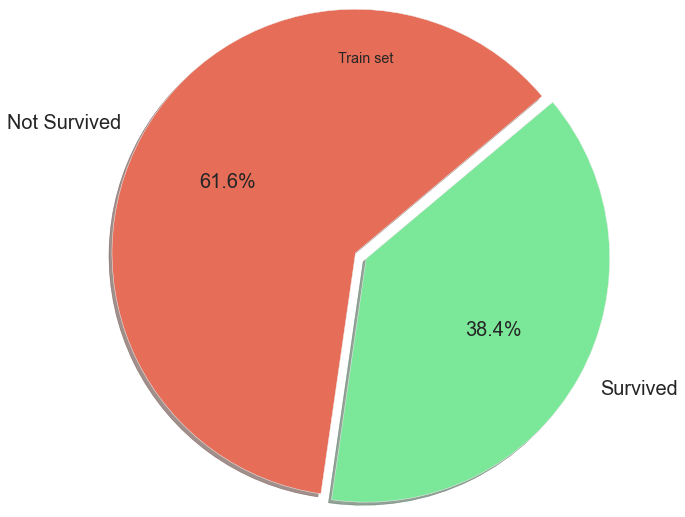

In [6]:
# build figure to contain the pie charts for train and test sets
fig, ax = plt.subplots(figsize=(15, 7))

color = ('#e66d57', '#7be899')

ax.pie(train_wd['survived'].value_counts(), data = train_wd, explode=[0.08,0], labels=("Not Survived", "Survived"), 
        autopct="%1.1f%%", colors=color, shadow=True, startangle=400, radius=1.6, textprops = {"fontsize":20})
ax.set_title('Train set')

plt.show();

## Summary 

In [7]:
display(train_wd.info()); display(test_wd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
passengerid    891 non-null int64
survived       891 non-null int64
pclass         891 non-null int64
name           891 non-null object
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
ticket         891 non-null object
fare           891 non-null float64
cabin          204 non-null object
embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
passengerid    418 non-null int64
pclass         418 non-null int64
name           418 non-null object
sex            418 non-null object
age            332 non-null float64
sibsp          418 non-null int64
parch          418 non-null int64
ticket         418 non-null object
fare           417 non-null float64
cabin          91 non-null object
embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

We notice right away that there are null values, most notable in the age and cabin attributes. The best approach is to evaluate one by one each attribute to get a feeling of the data set. This will also help understand wether we can combine attributes together to generate engineered features.

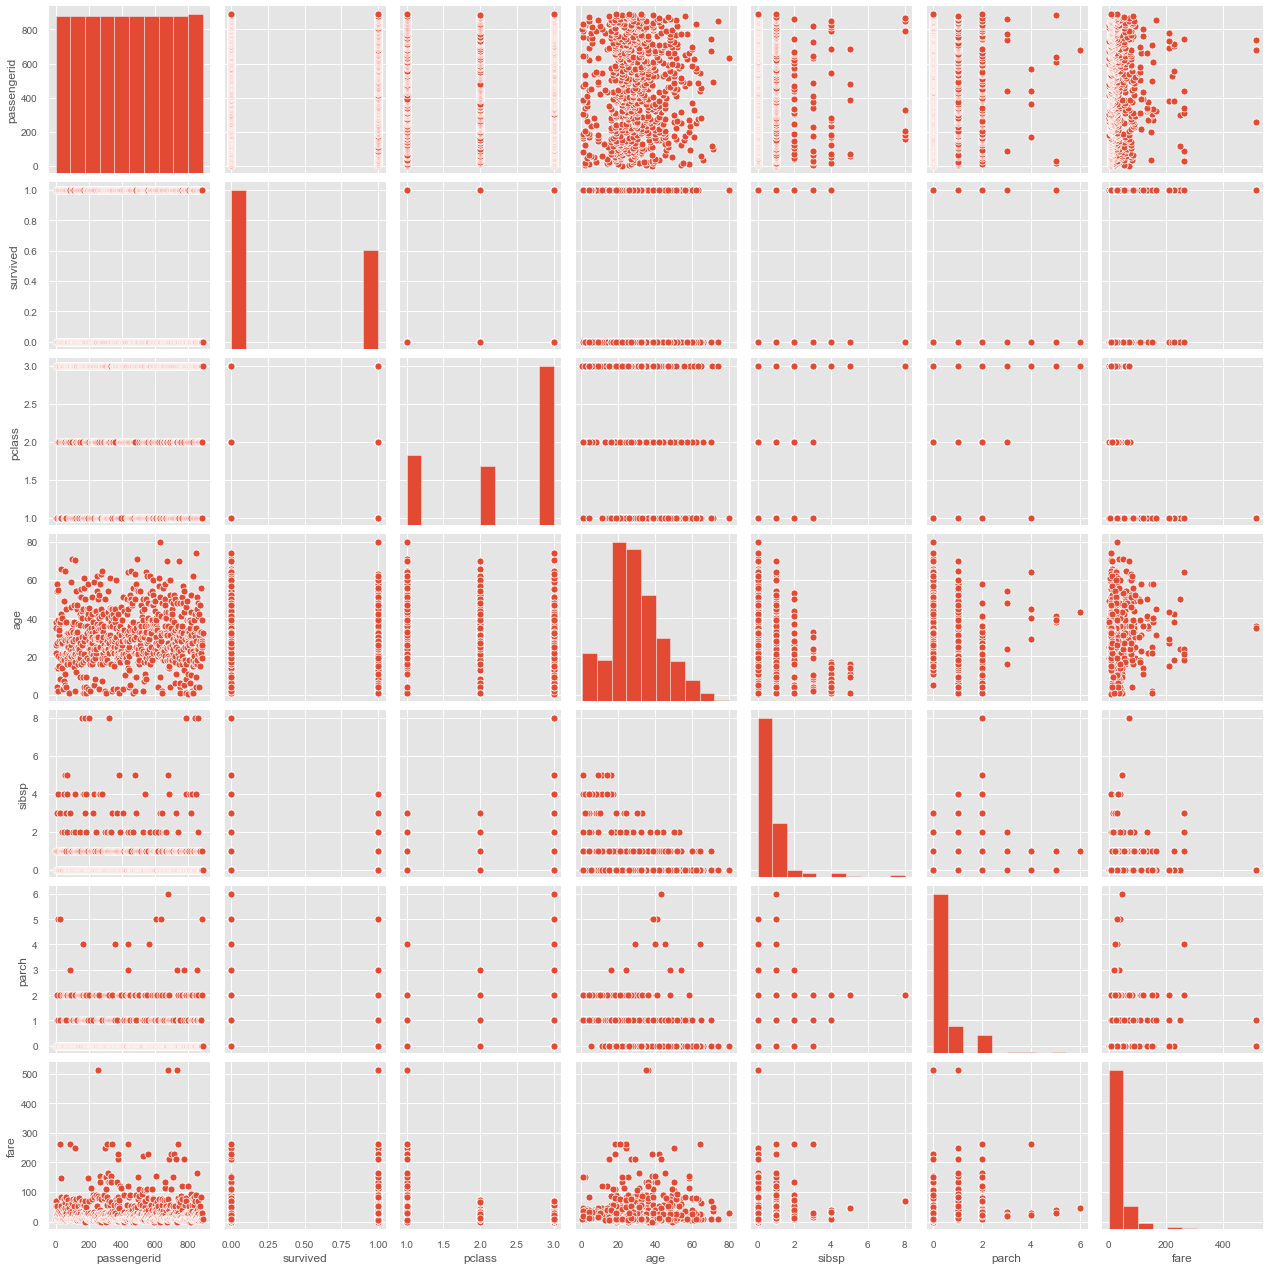

In [8]:
sns.pairplot(train_wd)

There is no outstanding relation that comes to mind when looking at the pairplot. I decide to dive into each attribute. 

## Attribute - Age

The age attribute has a high percentage of missing values. We will need to tackle this. Dropping the NaN column is not an option, as this will let us lose too many data points.

In [9]:
# percentage of missing values
100* train_wd['age'].isnull().sum() / train_wd.passengerid.count()

19.865319865319865

One option would be to use the mean value of the column to fill the missing points. However, this will not give us a good estimate of the variability of the attribute. In fact, looking at the distribution of the Age values, we notice that the distribution is quite spread. 


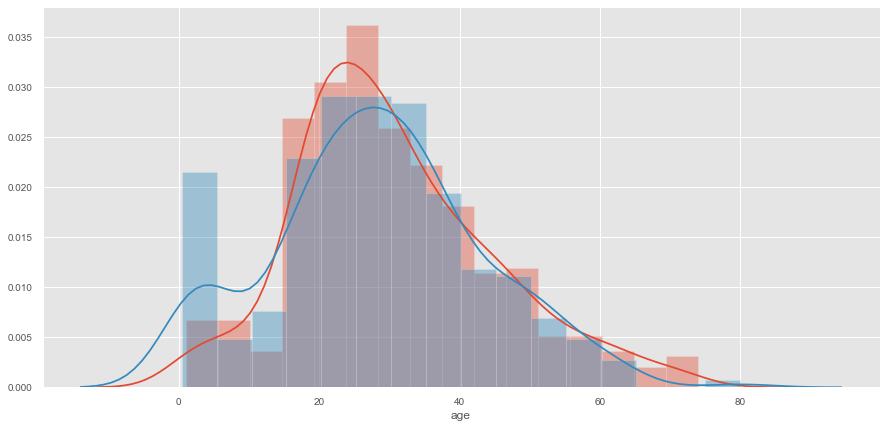

In [10]:
# evaluate the distribution of the age and wether there is a correlation with 

fig, ax= plt.subplots(figsize=(15, 7))

sns.distplot(train_wd[train_wd['survived'] == 0]['age'], hist=True, rug=False)
sns.distplot(train_wd[train_wd['survived'] == 1]['age'], hist=True, rug=False)



The distribution of the age attribute suggest a slighly better chance of survival at younger age, which make sense. We now have to impute the missing values. 

By looking at the dataset, we notice that the attribute carries the label for how the individual was regarded as (e.g. Mr. Miss, etc.). We could infer the age of the subgroups to have better estimates of the age by salutation groups. This will impute the Age missing values by looking at the salutation. 

## Attribute - Name

First, we will ineed to break down the name attribute into its building blocks. We notice that the structure of the name is in the following format {last_name}, {salutation}, {remaining_name}. I will extract this information.

In [11]:
# Defining functions to reduce the name variable into its building blocks

def extract_salutation(name):
    '''
    Split the name into its pieces. We get the salutation after the last name and coma.
    '''
    if ',' not in name:
        return 'outlier'
    else:
        after_comma = name.split(',')[1][1:]
        return after_comma.split('.')[0] if '.' in after_comma else '$'

def extract_last_name(name):
    '''
    Split the name into its pieces. We get the last name.
    '''
    return name.split(',')[0] if ',' in name else '$'

def extract_remaining_name(name):
    return name.split('.')[1] if '.' in name else '$'

apply_to_dfs('name', 'salutation', extract_salutation)

apply_to_dfs('name', 'last_name', extract_last_name)

apply_to_dfs('name', 'rem_name', extract_remaining_name)



In [12]:
display(train_wd.head()); 

display('The number of missing Salutation attributes is '+ str(train_wd['salutation'].isnull().sum()))

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,salutation,last_name,rem_name
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,Owen Harris
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,John Bradley (Florence Briggs Thayer)
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,Laina
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,Jacques Heath (Lily May Peel)
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,William Henry


'The number of missing Salutation attributes is 0'

We are not missing any Salutation value. Thus, we can use the approach of inferring the median age per salutation group to impute the missing age values. 

However, since we are analysing the name attribute, I'll continue focusing on it first and then go back and complete the Age attribute filling.

In [13]:
# extracting additional details from remaining part of the names
apply_to_dfs('rem_name', 'name_words_count', lambda name: len(name.split()) + 1)

apply_to_dfs('rem_name', 'has_brakets', lambda name: 1 if '(' in name else 0)

apply_to_dfs('rem_name', 'has_quot', lambda name: 1 if '"' in name else 0)

In [14]:
display(train_wd.head());

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,salutation,last_name,rem_name,name_words_count,has_brakets,has_quot
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,Owen Harris,3,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,John Bradley (Florence Briggs Thayer),6,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,Laina,2,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,Jacques Heath (Lily May Peel),6,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,William Henry,3,0,0


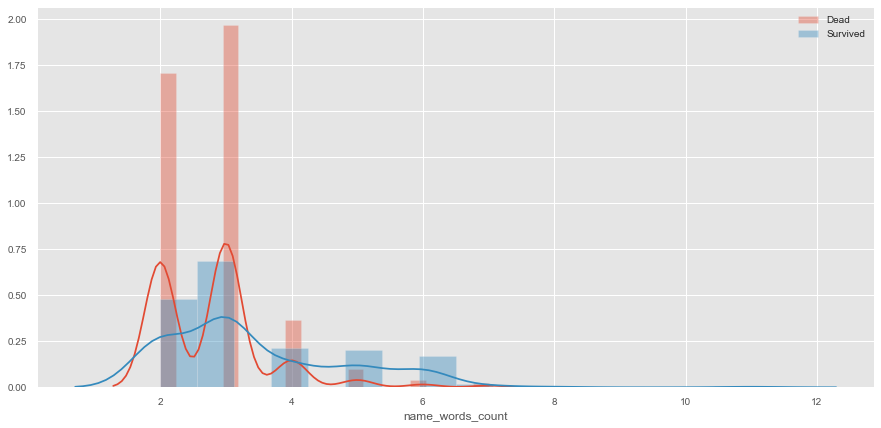

In [15]:
# evaluate the distribution of the age and wether there is a correlation with 

fig, ax= plt.subplots(figsize=(15, 7))

sns.distplot(train_wd[train_wd['survived'] == 0]['name_words_count'], hist=True, rug=False, label = 'Dead')
sns.distplot(train_wd[train_wd['survived'] == 1]['name_words_count'], hist=True, rug=False, label = 'Survived')

plt.legend()

It seems that in the Survived group, there is a higher chance of survival for individuals with a name word counts of three. However, I'm not yet confident that this attribute gives additional capability to our model. I will decide during the model selection step wether to keep this attribute or not. 

We can now proceed to impute the age to the missing values in the dataset. In particular, we will fill NaN values with the median obtain from salutation groups

In [16]:
# then we want to evaluate the median values for the salutation sub-groups
salutation_labels = list(train_wd['salutation'].unique())
salutation_median = {}

# obtain the median age value by salutation
for i in salutation_labels:
    salutation_median.update({i : stat.median(train_wd[(train_wd['salutation']==i) & (train_wd['age'].notnull())]['age'])})
    
# we generate an additional column that we fill missing value for age with the median
train_wd['age_opt'] = train_wd['age'].fillna(train_wd['salutation'].map(salutation_median))


train_wd.head(10)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,salutation,last_name,rem_name,name_words_count,has_brakets,has_quot,age_opt
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,Owen Harris,3,0,0,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,John Bradley (Florence Briggs Thayer),6,1,0,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,Laina,2,0,0,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,Jacques Heath (Lily May Peel),6,1,0,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,William Henry,3,0,0,35.0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr,Moran,James,2,0,0,30.0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr,McCarthy,Timothy J,3,0,0,54.0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master,Palsson,Gosta Leonard,3,0,0,2.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs,Johnson,Oscar W (Elisabeth Vilhelmina Berg),6,1,0,27.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs,Nasser,Nicholas (Adele Achem),4,1,0,14.0


We need to repeat this process on the test data. 

In [17]:
# then we want to evaluate the median values for the salutation sub-groups
salutation_labels = list(test_wd[test_wd['age'].notnull()]['salutation'].unique())
salutation_median = {}

# obtain the median age value by salutation
for i in salutation_labels:
    salutation_median.update({i : stat.median(test_wd[(test_wd['salutation']==i) & (test_wd['age'].notnull())]['age'])})

# we generate an additional column that we fill missing value for age with the median
test_wd['age_opt'] = test_wd['age'].fillna(test_wd['salutation'].map(salutation_median))

test_wd.head(); test_wd.info()

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,salutation,last_name,rem_name,name_words_count,has_brakets,has_quot,age_opt
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,Kelly,James,2,0,0,34.5
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,Wilkes,James (Ellen Needs),4,1,0,47.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,Myles,Thomas Francis,3,0,0,62.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,Wirz,Albert,2,0,0,27.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,Hirvonen,Alexander (Helga E Lindqvist),5,1,0,22.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
passengerid         418 non-null int64
pclass              418 non-null int64
name                418 non-null object
sex                 418 non-null object
age                 332 non-null float64
sibsp               418 non-null int64
parch               418 non-null int64
ticket              418 non-null object
fare                417 non-null float64
cabin               91 non-null object
embarked            418 non-null object
salutation          418 non-null object
last_name           418 non-null object
rem_name            418 non-null object
name_words_count    418 non-null int64
has_brakets         418 non-null int64
has_quot            418 non-null int64
age_opt             417 non-null float64
dtypes: float64(3), int64(7), object(8)
memory usage: 58.9+ KB


In [18]:
test_wd[test_wd.age_opt.isnull()]

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,salutation,last_name,rem_name,name_words_count,has_brakets,has_quot,age_opt
88,980,3,"O'Donoghue, Ms. Bridget",female,NaN,0,0,364856,7.75,NaN,Q,Ms,O'Donoghue,Bridget,2,0,0,NaN


we have only one label Ms in the test set with no age. We will manually impute this value using the median Ms age value of the training set.

In [19]:
train_wd[train_wd['salutation'] == 'Ms']['age']

443    28.0
Name: age, dtype: float64

In [20]:
test_wd.age_opt.fillna(28, inplace = True)

In [21]:
test_wd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
passengerid         418 non-null int64
pclass              418 non-null int64
name                418 non-null object
sex                 418 non-null object
age                 332 non-null float64
sibsp               418 non-null int64
parch               418 non-null int64
ticket              418 non-null object
fare                417 non-null float64
cabin               91 non-null object
embarked            418 non-null object
salutation          418 non-null object
last_name           418 non-null object
rem_name            418 non-null object
name_words_count    418 non-null int64
has_brakets         418 non-null int64
has_quot            418 non-null int64
age_opt             418 non-null float64
dtypes: float64(3), int64(7), object(8)
memory usage: 58.9+ KB


## Attributes - Ticket, Cabin, Fare and Embarked

Ticket and cabin numbers are variable with a lot of missing values. Since most of the folks didn't have a cabin associated, I will generate a label that uses the cabin first letter when available, thus specifying the cabin deck, or, alternatively will put unknown.

In [22]:
# here we populate the cabin nan values with unavailable else with the first letter of the deck cabin
apply_to_dfs('cabin', 'cabin_key', lambda c: c[0] if c == c else 'not_on_deck')


Now, we should try to use the ticket number and the fare to evaluate if there are groups that travelled together. Probably, this would match with cabin purchased closer to each other.

In [23]:
# here we generate a column to evaluate wether the titcket has a first letter (class ticket) or not
train_wd['ticket_letter'] = train_wd.ticket.astype(str).str[0].str.isalpha()

test_wd['ticket_letter'] = test_wd.ticket.astype(str).str[0].str.isalpha()

In [24]:
# we have only few missing values for Embarked. We use the mode to fill the missing 
train_wd['embarked_opt'] = train_wd.embarked.fillna('mode')
test_wd['embarked_opt'] = test_wd.embarked.fillna('mode')

For the cabin fare, we want to cluster by fare size. However, there is huge variance in the ticket fare sizes. 

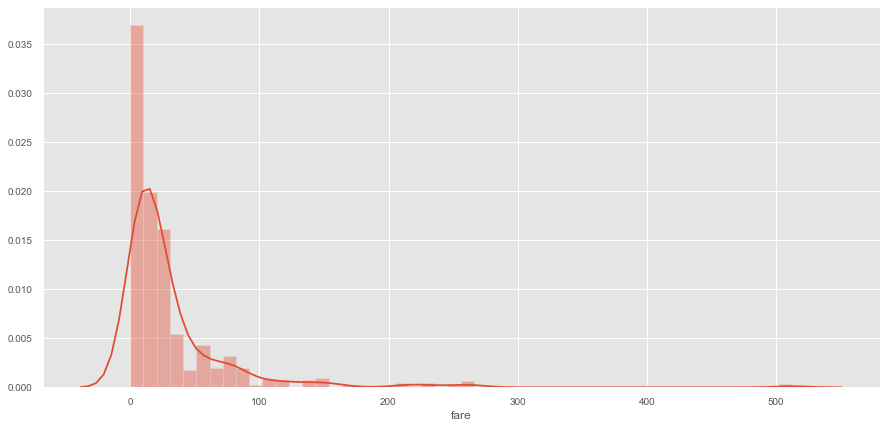

In [25]:
fig, ax= plt.subplots(figsize=(15, 7))

sns.distplot(train_wd['fare'], hist=True, rug=False)

In [26]:
# bring the fare to a log scale
train_wd['fare_log'] = np.log1p(train_wd['fare'])

test_wd['fare_log'] = np.log1p(test_wd['fare'])

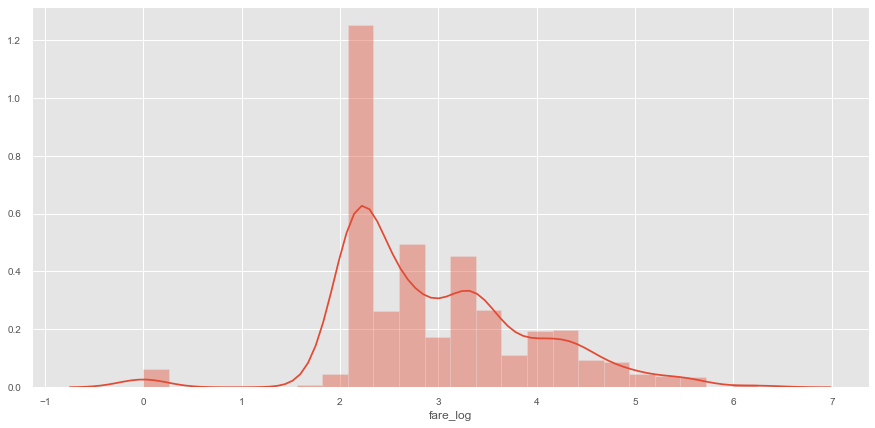

In [27]:
fig, ax= plt.subplots(figsize=(15, 7))

sns.distplot(train_wd['fare_log'], hist=True, rug=False)

We can now use the logarithmic scaled fare to generate two labels for the prices. We notice that the distribution is right skewed, so will create a label for fare <= 2.0 or not

In [28]:
# create grouping for logarithmic fare
train_wd['log_fare_below_2'] = train_wd['fare_log'] <=2

test_wd['log_fare_below_2'] = test_wd['fare_log'] <=2



In [29]:
# here we populate the cabin nan values with unavailable else with the first letter of the deck cabin
apply_to_dfs('cabin', 'cabin_key', lambda c: c[0] if c == c else 'not_on_deck')


# here we generate a column to evaluate wether the titcket has a first letter (class ticket) or not
train_wd['ticket_letter'] = train_wd.ticket.astype(str).str[0].str.isalpha()

test_wd['ticket_letter'] = test_wd.ticket.astype(str).str[0].str.isalpha()


# we have only few missing values for Embarked. We use the mode to fill the missing 
train_wd['embarked_opt'] = train_wd.embarked.fillna('mode')
test_wd['embarked_opt'] = test_wd.embarked.fillna('mode')

## Attributes - Siblings, parents

sibsp and parch together should give us the total size of the passenger family (extended). We are going to combine these two features and then use them to classify the family clusters.

- if the sum = 0 -> the passenger is independent
- if the family size > 3 we will identify it as big_family

In [30]:
train_wd['family_size'] = train_wd['sibsp'] + train_wd['parch']
test_wd['family_size'] = test_wd['sibsp'] + test_wd['parch']

apply_to_dfs('family_size', 'independent', lambda family_size: 1 if family_size == 0 else 0)
apply_to_dfs('family_size', 'big_family', lambda family_size: 1 if family_size > 3 else 0)



In [31]:
train_wd

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,salutation,last_name,rem_name,name_words_count,has_brakets,has_quot,age_opt,cabin_key,ticket_letter,embarked_opt,fare_log,log_fare_below_2,family_size,independent,big_family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,Owen Harris,3,0,0,22.0,not_on_deck,True,S,2.110213,False,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,John Bradley (Florence Briggs Thayer),6,1,0,38.0,C,True,C,4.280593,False,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,Laina,2,0,0,26.0,not_on_deck,True,S,2.188856,False,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,Jacques Heath (Lily May Peel),6,1,0,35.0,C,False,S,3.990834,False,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,William Henry,3,0,0,35.0,not_on_deck,False,S,2.202765,False,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,Montvila,Juozas,2,0,0,27.0,not_on_deck,False,S,2.639057,False,0,1,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,Graham,Margaret Edith,3,0,0,19.0,B,False,S,3.433987,False,0,1,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss,Johnston,"Catherine Helen ""Carrie""",4,0,1,21.0,not_on_deck,True,S,3.196630,False,3,0,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,Behr,Karl Howell,3,0,0,26.0,C,False,C,3.433987,False,0,1,0


We are almost ready to select the important features, the model and to train it to our test data. One last preliminary step to do is to remove redundant columns as well as the target variable from our training dataset.

In [32]:
#Set index
train = train_wd.set_index('passengerid')
test = test_wd.set_index('passengerid')

display(train.head()); display(test.head())

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,salutation,last_name,rem_name,name_words_count,has_brakets,has_quot,age_opt,cabin_key,ticket_letter,embarked_opt,fare_log,log_fare_below_2,family_size,independent,big_family
passengerid,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,Owen Harris,3,0,0,22.0,not_on_deck,True,S,2.110213,False,1,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,John Bradley (Florence Briggs Thayer),6,1,0,38.0,C,True,C,4.280593,False,1,0,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,Laina,2,0,0,26.0,not_on_deck,True,S,2.188856,False,0,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,Jacques Heath (Lily May Peel),6,1,0,35.0,C,False,S,3.990834,False,1,0,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,William Henry,3,0,0,35.0,not_on_deck,False,S,2.202765,False,0,1,0


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,salutation,last_name,rem_name,name_words_count,has_brakets,has_quot,age_opt,cabin_key,ticket_letter,embarked_opt,fare_log,log_fare_below_2,family_size,independent,big_family
passengerid,,,,,,,,,,,,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,Kelly,James,2,0,0,34.5,not_on_deck,False,Q,2.178064,False,0,1,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,Wilkes,James (Ellen Needs),4,1,0,47.0,not_on_deck,False,S,2.079442,False,1,0,0
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,Myles,Thomas Francis,3,0,0,62.0,not_on_deck,False,Q,2.369075,False,0,1,0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,Wirz,Albert,2,0,0,27.0,not_on_deck,False,S,2.268252,False,0,1,0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,Hirvonen,Alexander (Helga E Lindqvist),5,1,0,22.0,not_on_deck,False,S,2.586824,False,2,0,0


In [33]:


# we encode categorical variables appropriately
make_dummies('embarked_opt')
make_dummies('pclass')
make_dummies('sex')
make_dummies('cabin_key')
make_dummies('salutation')



In [34]:
# now we want to remove redundant information, we will keep engineered features and remove the rest

to_drop = ['name', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'last_name', 'rem_name', 'fare_log']

train.drop(to_drop, axis = 1, inplace = True)
test.drop(to_drop, axis = 1, inplace = True)

In [35]:
display(train.head()); display(test.head())

,survived,name_words_count,has_brakets,has_quot,age_opt,ticket_letter,log_fare_below_2,family_size,independent,big_family,embarked_opt_Q,embarked_opt_S,pclass_2,pclass_3,sex_male,cabin_key_B,cabin_key_C,cabin_key_D,cabin_key_E,cabin_key_F,cabin_key_G,cabin_key_not_on_deck,salutation_Dr,salutation_Master,salutation_Miss,salutation_Mr,salutation_Mrs,salutation_Ms,salutation_Rev
passengerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,3,0,0,22.0,True,False,1,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,1,6,1,0,38.0,True,False,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,1,2,0,0,26.0,True,False,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,1,6,1,0,35.0,False,False,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0,3,0,0,35.0,False,False,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0


,name_words_count,has_brakets,has_quot,age_opt,ticket_letter,log_fare_below_2,family_size,independent,big_family,embarked_opt_Q,embarked_opt_S,pclass_2,pclass_3,sex_male,cabin_key_B,cabin_key_C,cabin_key_D,cabin_key_E,cabin_key_F,cabin_key_G,cabin_key_not_on_deck,salutation_Dr,salutation_Master,salutation_Miss,salutation_Mr,salutation_Mrs,salutation_Ms,salutation_Rev
passengerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
892,2,0,0,34.5,False,False,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
893,4,1,0,47.0,False,False,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
894,3,0,0,62.0,False,False,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
895,2,0,0,27.0,False,False,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
896,5,1,0,22.0,False,False,2,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [36]:
# drop('survived', only_train=True)

In [37]:
display(train.info()); display(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 29 columns):
survived                 891 non-null int64
name_words_count         891 non-null int64
has_brakets              891 non-null int64
has_quot                 891 non-null int64
age_opt                  891 non-null float64
ticket_letter            891 non-null bool
log_fare_below_2         891 non-null bool
family_size              891 non-null int64
independent              891 non-null int64
big_family               891 non-null int64
embarked_opt_Q           891 non-null uint8
embarked_opt_S           891 non-null uint8
pclass_2                 891 non-null uint8
pclass_3                 891 non-null uint8
sex_male                 891 non-null uint8
cabin_key_B              891 non-null uint8
cabin_key_C              891 non-null uint8
cabin_key_D              891 non-null uint8
cabin_key_E              891 non-null uint8
cabin_key_F              891 non-null uint8
cabin_key_G    

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 28 columns):
name_words_count         418 non-null int64
has_brakets              418 non-null int64
has_quot                 418 non-null int64
age_opt                  418 non-null float64
ticket_letter            418 non-null bool
log_fare_below_2         418 non-null bool
family_size              418 non-null int64
independent              418 non-null int64
big_family               418 non-null int64
embarked_opt_Q           418 non-null uint8
embarked_opt_S           418 non-null uint8
pclass_2                 418 non-null uint8
pclass_3                 418 non-null uint8
sex_male                 418 non-null uint8
cabin_key_B              418 non-null uint8
cabin_key_C              418 non-null uint8
cabin_key_D              418 non-null uint8
cabin_key_E              418 non-null uint8
cabin_key_F              418 non-null uint8
cabin_key_G              418 non-null uint8
cabin_key_no

None

We are ready to proceed to the modelling phase. 

# 4. Modelling

Considering this notebook has the objective to test and end-to-end Machine Learning project, I will use a variety of approaches to test which is more effective. In particular, I want to explore feature importance, use dimensionality reduction to visualize the data and apply different models to obtain the best result. 

The end output will, however, try to use the simplest modelling so that is easier to explain the model's output. 

## Feature evaluation

Here I use a Random Forest model to evaluate the importance of each feture. 

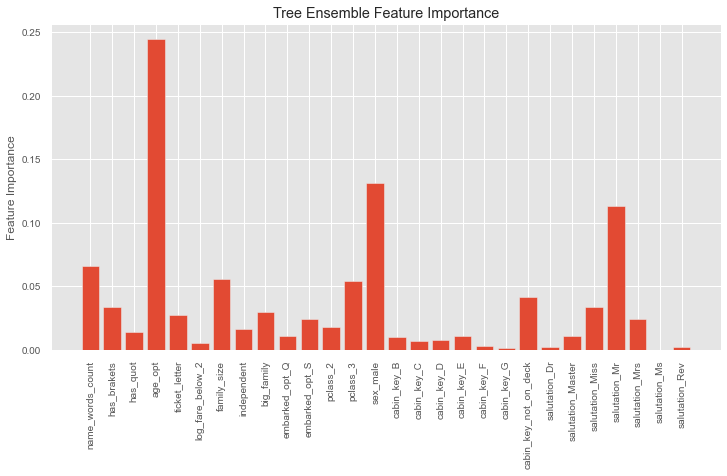

In [38]:
# prepare the dataset for the classifier 
X, y = train.iloc[:,1:], train.iloc[:,0]
df = train

# evaluate feature importance and plot them
feat_labels = df.columns[1:]
rf = RandomForestClassifier()
rf.fit(X, y)
plt.figure(figsize=(12,6))
plt.bar(range(len(feat_labels)), rf.feature_importances_)
plt.xticks(range(len(feat_labels)), feat_labels, rotation =90)
plt.ylabel('Feature Importance')
plt.title('Tree Ensemble Feature Importance')
plt.show();

It is clear that age and sex, followed by family size have a really high impact on the survival rate. I'm not convinved by the realtively high importance of the name characteristics as well as the importance of the name salutation. Since we used the salutation to fill the missing age values, it is possible that some information is redundant there. There could be also redundancy in the family size with the additional features enginneered from there (independent travellere and big family).

## Dimensionality reduction with PCA

Dimensionality reduction is useful to evaluate which of the attributes can explain most of the variance of the data set. It is always useful to reduce the dimensionality of a dataset to avoid overfitting. I'm going to use PCA here to evaluate the attributes. I'm going to reduce the data set (currently 28 attributes) to a vector containing 2 and 3 attributes. This will help us to visualize the data points in a dimensional space that is easy to understand. 




### 2D representation

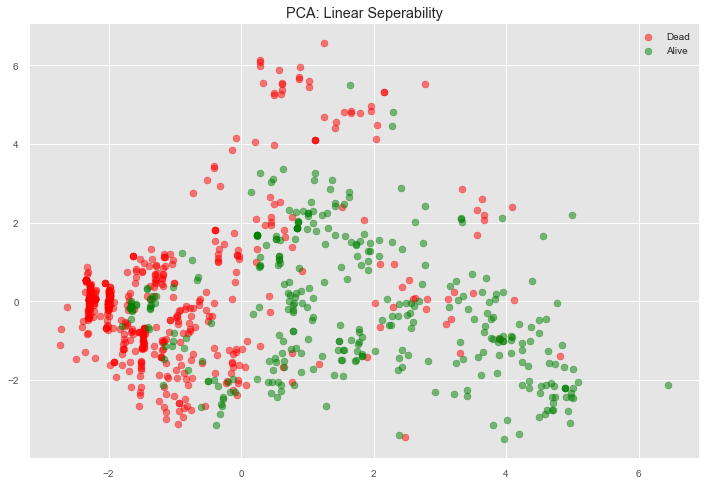

In [39]:
# prepare train data for PCA, scaling data 
X_pca_2d = train.copy()
X_pca_2d = StandardScaler().fit_transform(X_pca_2d)

#instantiate PCA
pca = PCA(n_components = 2)
X_redu_2d = pca.fit_transform(X_pca_2d)

died_2d = X_redu_2d[y == 0]
live_2d = X_redu_2d[y == 1]
comp =[0,1]

fig = plt.figure(figsize = (12,8))
plt.scatter(died_2d[:,0].reshape(1,-1), died_2d[:,1].reshape(1,-1), c = 'red', label = 'Dead', alpha = 0.5)
plt.scatter(live_2d[:,0].reshape(1,-1), live_2d[:,1].reshape(1,-1), c = 'green', label = 'Survived', alpha = 0.5)
plt.title('PCA: Linear Seperability')
plt.legend(['Dead', 'Alive'])

plt.show();

Reducing the dataset into a 2-axis vector is useful to determine wether there is linearity in the data. We can see that, despite being somewhat mixed, the data is clearly clusterized although quite dispersed. 

### 3D representation

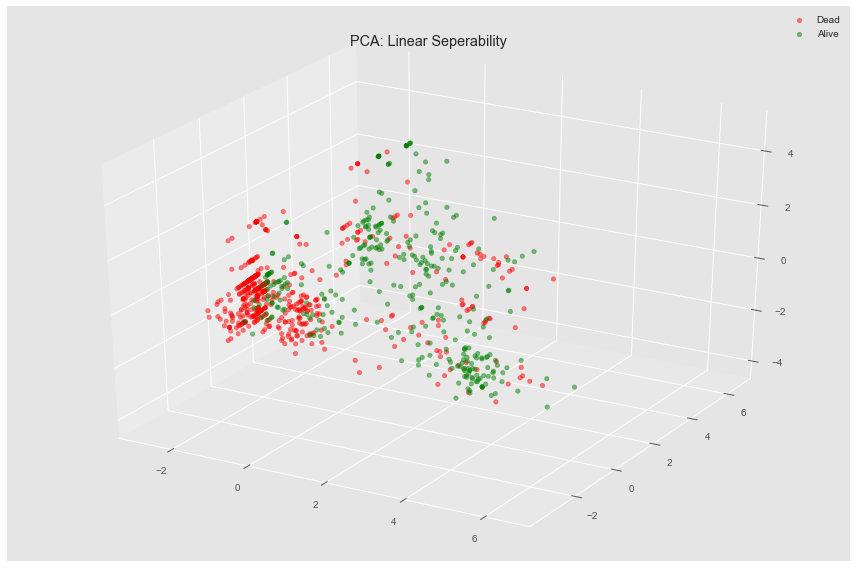

In [40]:

#Scaling down Data
X_pca_3d = train.copy()
X_pca_3d = StandardScaler().fit_transform(X_pca_3d)

#instantiate PCA
pca = PCA(n_components = 3)
X_redu_3d = pca.fit_transform(X_pca_3d)

died_3d = X_redu_3d[y == 0]
live_3d = X_redu_3d[y == 1]
comp =[0,1]

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d', )
ax.scatter(died_3d[:,0].reshape(1,-1), died_3d[:,1].reshape(1,-1),died_3d[:,2].reshape(1,-1), c = 'red', label = 'Dead', alpha = 0.5)
ax.scatter(live_3d[:,0].reshape(1,-1), live_3d[:,1].reshape(1,-1),live_3d[:,2].reshape(1,-1), c = 'green', label = 'Survived', alpha = 0.5)
plt.title('PCA: Linear Seperability')
plt.legend(['Dead', 'Alive'])
plt.tight_layout()

plt.show();


### Dimensionality reduction conclusion

Despite the clusters are disperesed and mixed at the boundaries, it is possible to see that there are indeed defined clusters that identify survived versus death passengers. This suggest that the attributes in the dataset contain the characteristics to explain the chances of survival for the passengers. 

Thus, chances of survival weren't caused by pure luck. 

## Model selection

In [41]:
#Set without scaling
X, X_test, y, y_test = train_test_split(train.iloc[:,1:], train.iloc[:,0], test_size = 0.2, stratify = train.iloc[:,0])
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.11, stratify = y)



print('Training set size: ', X_train.shape, '\n','Validation set size: ', X_validation.shape, '\n','Test set size:', X_test.shape)

Training set size:  (633, 28) 
 Validation set size:  (79, 28) 
 Test set size: (179, 28)


In [42]:
# prepare the training set
X_scaled = X_train.copy()
sc = StandardScaler()
X_scaled = sc.fit_transform(X_scaled)

# set model to train and evaluate the mean cross validation score
models = {'KNN: ': KNeighborsClassifier(),
         'Logistic: ': LogisticRegressionCV(max_iter = 200), # had to increase the number of iteration to fit to convergence
         'Naive Bayes: ': GaussianNB(),
         'Support Vector Machine:' : SVC(kernel = 'linear'),
         'Random Forest: ': RandomForestClassifier(n_estimators = 100, n_jobs = -1),
         'AdaBoost: ': AdaBoostClassifier(),
         'GBM: ' : GradientBoostingClassifier()}

for i, mod in enumerate(models.values()):
    print(list(models.keys())[i],cross_val_score(mod, X_scaled, y_train, cv = 10).mean())

KNN:  0.7803819444444444
Logistic:  0.8261904761904761
Naive Bayes:  0.6430803571428572
Support Vector Machine: 0.8150793650793651
Random Forest:  0.7913938492063491
AdaBoost:  0.8167410714285713
GBM:  0.8261408730158729


## Feature selection

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LogisticRegressionCV(Cs=10, class_weight=None, cv=None,
                                     dual=False, fit_intercept=True,
                                     intercept_scaling=1.0, l1_ratios=None,
                                     max_iter=200, multi_class='auto',
                                     n_jobs=None, penalty='l2',
                                     random_state=None, refit=True,
                                     scoring=None, solver='lbfgs', tol=0.0001,
                                     verbose=0),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x1271ff110>,
 <a list of 30 Text major ticklabel objects>)

Text(0.5, 0, '# of features')

Text(0, 0.5, 'Classifier Accuracy')

Text(0.5, 1.0, 'Logistic: ')

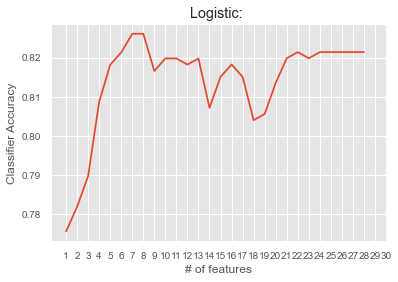

Feature to be Omitted:  ['name_words_count' 'has_brakets' 'age_opt' 'ticket_letter' 'family_size'
 'independent' 'embarked_opt_Q' 'embarked_opt_S' 'pclass_2' 'cabin_key_B'
 'cabin_key_C' 'cabin_key_D' 'cabin_key_E' 'cabin_key_F' 'cabin_key_G'
 'salutation_Dr' 'salutation_Miss' 'salutation_Mr' 'salutation_Mrs'
 'salutation_Ms' 'salutation_Rev']


RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x123ca50d0>,
 <a list of 30 Text major ticklabel objects>)

Text(0.5, 0, '# of features')

Text(0, 0.5, 'Classifier Accuracy')

Text(0.5, 1.0, 'Random Forest')

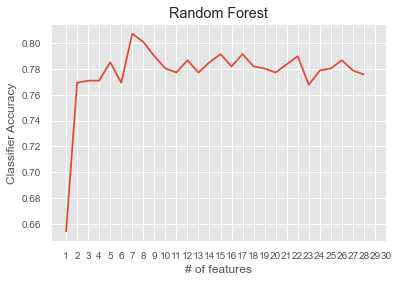

Feature to be Omitted:  ['has_brakets' 'has_quot' 'ticket_letter' 'log_fare_below_2' 'independent'
 'big_family' 'embarked_opt_Q' 'embarked_opt_S' 'pclass_2' 'cabin_key_B'
 'cabin_key_C' 'cabin_key_D' 'cabin_key_E' 'cabin_key_F' 'cabin_key_G'
 'salutation_Dr' 'salutation_Master' 'salutation_Miss' 'salutation_Mrs'
 'salutation_Ms' 'salutation_Rev']


RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                    coef0=0.0, decision_function_shape='ovr', degree=3,
                    gamma='scale', kernel='linear', max_iter=-1,
                    probability=False, random_state=None, shrinking=True,
                    tol=0.001, verbose=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x1234c9c90>,
 <a list of 30 Text major ticklabel objects>)

Text(0.5, 0, '# of features')

Text(0, 0.5, 'Classifier Accuracy')

Text(0.5, 1.0, 'Support Vector Machine:')

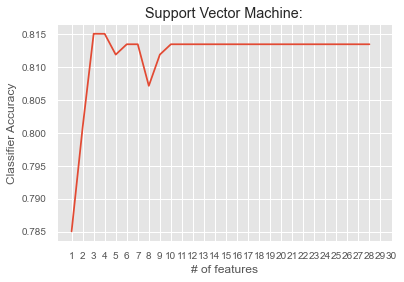

Feature to be Omitted:  ['name_words_count' 'has_brakets' 'has_quot' 'age_opt' 'ticket_letter'
 'log_fare_below_2' 'family_size' 'independent' 'embarked_opt_Q'
 'embarked_opt_S' 'pclass_2' 'pclass_3' 'cabin_key_B' 'cabin_key_C'
 'cabin_key_D' 'cabin_key_E' 'cabin_key_F' 'cabin_key_G'
 'cabin_key_not_on_deck' 'salutation_Dr' 'salutation_Miss' 'salutation_Mr'
 'salutation_Mrs' 'salutation_Ms' 'salutation_Rev']


RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                   learning_rate=1.0, n_estimators=50,
                                   random_state=None),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x126dcfe90>,
 <a list of 30 Text major ticklabel objects>)

Text(0.5, 0, '# of features')

Text(0, 0.5, 'Classifier Accuracy')

Text(0.5, 1.0, 'AdaBoost: ')

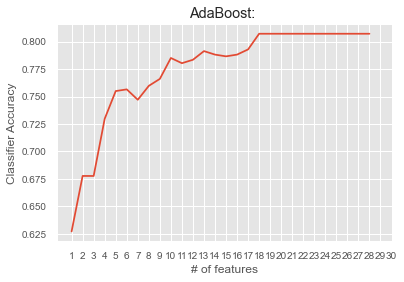

Feature to be Omitted:  ['has_brakets' 'ticket_letter' 'independent' 'big_family' 'embarked_opt_Q'
 'embarked_opt_S' 'cabin_key_F' 'salutation_Dr' 'salutation_Miss'
 'salutation_Ms']


RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1, loss='deviance',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=None,
                                           presort='deprecated',
                                          

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x1220a8c10>,
 <a list of 30 Text major ticklabel objects>)

Text(0.5, 0, '# of features')

Text(0, 0.5, 'Classifier Accuracy')

Text(0.5, 1.0, 'GBM: ')

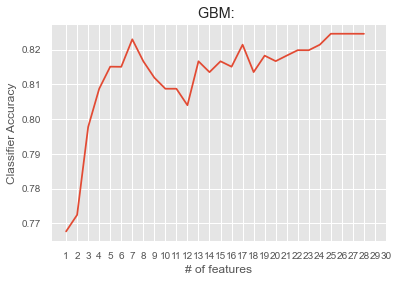

Feature to be Omitted:  ['independent' 'cabin_key_G' 'salutation_Ms']


In [43]:
#Dropping KNN and Naive Bayes, that performed poorly
models = {'Logistic: ': LogisticRegressionCV(max_iter = 200),
          'Random Forest': RandomForestClassifier(),
          'Support Vector Machine:' : SVC(kernel = 'linear'),
          'AdaBoost: ': AdaBoostClassifier(),
          'GBM: ' : GradientBoostingClassifier()}

for i , mod in enumerate(models.values()):
    r = RFECV(mod, cv = StratifiedKFold(5), scoring = 'accuracy')
    r.fit(X_scaled, y_train)
    plt.figure()
    plt.plot(range(1, len(r.grid_scores_)+1), r.grid_scores_)
    plt.xticks([1,2,3,4,5,6,7,8,9,10, 11, 12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30])
    plt.xlabel('# of features')
    plt.ylabel('Classifier Accuracy')
    plt.title(str(list(models.keys())[i]))
    plt.show();
    print('Feature to be Omitted: ', train.columns[1:][np.array(r.ranking_)!=1].values)

There are a number of attributes that can be omitted to improve the model performance. We will proceed to model tweaking now. Of the model initially used, we will optimize the best performer (LogisticRegression, SVC, RandomForest, AdaBoost, GradientBoosting)

## Model tweaking - Logistic Regression

In [44]:
overall_res = pd.DataFrame(columns=['Classifier', 'Best_clf_retrained', 'Best_test_score', 'Validation'],)


In [45]:
log = LogisticRegressionCV()
sc = StandardScaler()
clf_name = 'Logistic Regression'

# applying feature selection
to_drop_log = ['name_words_count', 'has_brakets', 'ticket_letter', 'log_fare_below_2', 'independent', 
           'embarked_opt_Q', 'embarked_opt_S', 'cabin_key_B', 'cabin_key_C', 
           'cabin_key_D', 'cabin_key_E', 'cabin_key_F', 'cabin_key_G', 'salutation_Dr', 
           'salutation_Miss', 'salutation_Mr', 'salutation_Ms']

X_train_log = X_train.copy()
X_train_log.drop(to_drop_log, axis = 1, inplace = True)

X_validation_log = X_validation.copy()
X_validation_log.drop(to_drop_log, axis = 1, inplace = True)


#Model performance evaluation with feature selected
pipe = Pipeline([('sc', sc), ('classifier', log)])
fit_params = {}

gs = GridSearchCV(pipe, fit_params, cv = 10, n_jobs = -1, return_train_score = True)
gs.fit(X_train_log, y_train)

print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))

print('Validation Performance of Best Performer', )


pipe.fit(X_train_log, y_train)
pred = pipe.predict(X_validation_log)
print('Best Estimator Validation Performance', accuracy_score(y_validation, pred))

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_, 
                            'Best_test_score': gs.best_score_,
                                  'Validation': accuracy_score(y_validation, pred)}, ignore_index=True);

Best performing classifier parameters (score 0.8245535714285713):
{}
Validation Performance of Best Performer
Best Estimator Validation Performance 0.7721518987341772


## Model tweaking - SVC Vector Machine

In [46]:
svc = SVC()
sc = StandardScaler()
clf_name = 'Support Vector Machine'

# applying feature selection
to_drop = ['name_words_count', 'has_brakets', 'has_quot', 'age_opt', 'ticket_letter', 'log_fare_below_2', 
           'family_size', 'independent', 'embarked_opt_Q', 'embarked_opt_S', 'pclass_2', 'pclass_3', 
           'cabin_key_B', 'cabin_key_C', 'cabin_key_D', 'cabin_key_E', 'cabin_key_F', 'cabin_key_not_on_deck',
           'salutation_Dr', 'salutation_Miss', 'salutation_Mr', 'salutation_Mrs', 'salutation_Ms', 'salutation_Rev']

X_train_svc = X_train.copy()
X_train_svc.drop(to_drop, axis = 1, inplace = True)

X_validation_svc = X_validation.copy()
X_validation_svc.drop(to_drop, axis = 1, inplace = True)

#Without Feature Selection
pipe = Pipeline([('sc', sc), ('classifier', svc)])
fit_params = {'classifier__kernel':['rbf','linear', 'poly'], 'classifier__degree':[2, 3, 4, 5]}

gs = GridSearchCV(pipe, fit_params, cv = 10, return_train_score = True)
gs.fit(X_train_svc, y_train)



print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))

pipe.set_params(classifier__degree = gs.best_params_['classifier__degree'], classifier__kernel = gs.best_params_['classifier__kernel'])
pipe.fit(X_train_svc, y_train)
pred = pipe.predict(X_validation_svc)
print('Best Estimator Validation Performance', accuracy_score(y_validation, pred))

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_, 
                            'Best_test_score': gs.best_score_,
                                  'Validation': accuracy_score(y_validation, pred)}, ignore_index=True);

Best performing classifier parameters (score 0.8229662698412697):
{'classifier__degree': 2, 'classifier__kernel': 'rbf'}
Best Estimator Validation Performance 0.7848101265822784


## Model tweaking - RandomForestClassifier

In [47]:
rf = RandomForestClassifier()
sc = StandardScaler()
clf_name = 'Random Forest Classifier'


# applying feature selection
to_drop = ['salutation_Ms']

X_train_rf = X_train.copy()
X_train_rf.drop(to_drop, axis = 1, inplace = True)

X_validation_rf = X_validation.copy()
X_validation_rf.drop(to_drop, axis = 1, inplace = True)


# pipeling and training
pipe = Pipeline([('sc', sc), ('clf', rf)])
fit_params = {'clf__n_estimators':[10],
              'clf__min_samples_split':[2,3,4,5,6,7,8,9,10],
              'clf__min_samples_leaf':[1,2,3,4,5,6,7],
              'clf__max_features':[None,'auto']}

gs = GridSearchCV(pipe, fit_params, cv = 10,n_jobs = -1, return_train_score = True)
gs.fit(X_train_rf, y_train)


print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_, gs.best_params_))


pipe.set_params(clf__min_samples_leaf = gs.best_params_['clf__min_samples_leaf'], clf__min_samples_split = gs.best_params_['clf__min_samples_split'])
pipe.fit(X_train_rf, y_train)
pred = pipe.predict(X_validation_rf)
print('Best Estimator Validation Performance', accuracy_score(y_validation, pred))

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_, 
                            'Best_test_score': gs.best_score_,
                                  'Validation': accuracy_score(y_validation, pred)}, ignore_index=True);

Best performing classifier parameters (score 0.8372767857142858):
{'clf__max_features': 'auto', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 10}
Best Estimator Validation Performance 0.810126582278481


## Model tweaking - AdaBoost

In [48]:
sc = StandardScaler()
ab = AdaBoostClassifier()
clf_name = 'AdaBoost'

# Make pipeline
pipe = Pipeline([('sc', sc),('clf', ab)])
fit_params = {'clf__n_estimators':[200],
              'clf__base_estimator':[
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=1, min_samples_split=2),                  
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=2, min_samples_split=4), 
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=2, min_samples_split=5), 
                  DecisionTreeClassifier(criterion='gini',   
                      min_samples_leaf=2, min_samples_split=6), 
                  DecisionTreeClassifier(criterion='gini',                                          
                      min_samples_leaf=2, min_samples_split=10),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=3, min_samples_split=6), 
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=3, min_samples_split=7), 
                  DecisionTreeClassifier(criterion='gini',   
                      min_samples_leaf=3, min_samples_split=8),                         
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=2, min_samples_split=13),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=4, min_samples_split=10),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=4, min_samples_split=13),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=6, min_samples_split=13),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=8, min_samples_split=18),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=10, min_samples_split=22),
              ]}

# applying feature selection
to_drop = ['has_brakets', 'ticket_letter', 'independent', 'big_family', 'embarked_opt_Q',
           'embarked_opt_S', 'cabin_key_B', 'cabin_key_C', 'cabin_key_D', 'cabin_key_F',
           'salutation_Master', 'salutation_Miss']

X_train_ab = X_train.copy()
X_train_ab.drop(to_drop, axis = 1, inplace = True)

X_validation_ab = X_validation.copy()
X_validation_ab.drop(to_drop, axis = 1, inplace = True)
                                                                   
# Initiate GridSearchCV
gs = GridSearchCV(pipe, fit_params, cv=10, n_jobs = -1, return_train_score = True)

# Fit GridSearchCV
gs.fit(X, y)

cv = pd.DataFrame(gs.cv_results_) # To check all the classifier performances


print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_, gs.best_params_))

# pipeline and training
pipe.set_params(clf__base_estimator = gs.best_params_['clf__base_estimator'])
pipe.fit(X_train_ab, y_train)
pred = pipe.predict(X_validation_ab)
print('Best Estimator Validation Performance', accuracy_score(y_validation, pred))



overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_, 
                            'Best_test_score': gs.best_score_,
                                  'Validation': accuracy_score(y_validation, pred)}, ignore_index=True);

Best performing classifier parameters (score 0.7906494522691706):
{'clf__base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'clf__n_estimators': 200}
Best Estimator Validation Performance 0.7215189873417721


## Model tweaking - GradientBoost

In [49]:
gb = GradientBoostingClassifier()
sc = StandardScaler()
clf_name = 'Gradient Boosting Machine'

# applying feature selection
to_drop = ['has_brakets', 'has_quot', 'ticket_letter', 'log_fare_below_2', 'independent', 'big_family', 
           'embarked_opt_Q', 'embarked_opt_S', 'pclass_2', 'cabin_key_B', 'cabin_key_C', 'cabin_key_D', 
           'cabin_key_E', 'cabin_key_F', 'cabin_key_G', 'salutation_Dr', 'salutation_Master', 'salutation_Miss', 
           'salutation_Mrs', 'salutation_Ms', 'salutation_Rev']

X_train_gb = X_train.copy()
X_train_gb.drop(to_drop, axis = 1, inplace = True)

X_validation_gb = X_validation.copy()
X_validation_gb.drop(to_drop, axis = 1, inplace = True)

# pipeline and training
pipe = Pipeline([('sc', sc), ('clf', gb)])
fit_params = {'clf__loss': ['deviance', 'exponential'],
             'clf__learning_rate': [0.001, 0.01, 0.1, 1],
             'clf__max_depth': [3,4,5,6,7,8],
             'clf__min_samples_split': [2,3,4,5]}


gs = GridSearchCV(pipe, fit_params, n_jobs = -1, cv = 10, return_train_score = True)
gs.fit(X_train_gb, y_train)

print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))


pipe.set_params(clf__learning_rate = gs.best_params_['clf__learning_rate'])
pipe.fit(X_train_gb, y_train)
pred = pipe.predict(X_validation_gb)
print('Best Estimator Validation Performance', accuracy_score(y_validation, pred))


overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_, 
                            'Best_test_score': gs.best_score_,
                                  'Validation': accuracy_score(y_validation, pred)}, ignore_index=True);

Best performing classifier parameters (score 0.818204365079365):
{'clf__learning_rate': 0.01, 'clf__loss': 'deviance', 'clf__max_depth': 8, 'clf__min_samples_split': 2}
Best Estimator Validation Performance 0.810126582278481


## Model tweaking - summary and overall performances

,Classifier,Best_clf_retrained,Best_test_score,Validation
0,Logistic Regression,"(StandardScaler(copy=True, with_mean=True, wit...",82.455357,77.215190
1,Support Vector Machine,"(StandardScaler(copy=True, with_mean=True, wit...",82.296627,78.481013
2,Random Forest Classifier,"(StandardScaler(copy=True, with_mean=True, wit...",83.727679,81.012658
3,AdaBoost,"(StandardScaler(copy=True, with_mean=True, wit...",79.064945,72.151899
4,Gradient Boosting Machine,"(StandardScaler(copy=True, with_mean=True, wit...",81.820437,81.012658


([<matplotlib.axis.XTick at 0x126e355d0>,
 [Text(0, 0, 'Logistic Regression'),
  Text(0, 0, 'Support Vector Machine'),
  Text(0, 0, 'Random Forest Classifier'),
  Text(0, 0, 'AdaBoost'),
  Text(0, 0, 'Gradient Boosting Machine')])

Text(0.5, 1.0, 'Model Performance')

Text(0, 0.5, 'Performance')

(0.0, 100.0)

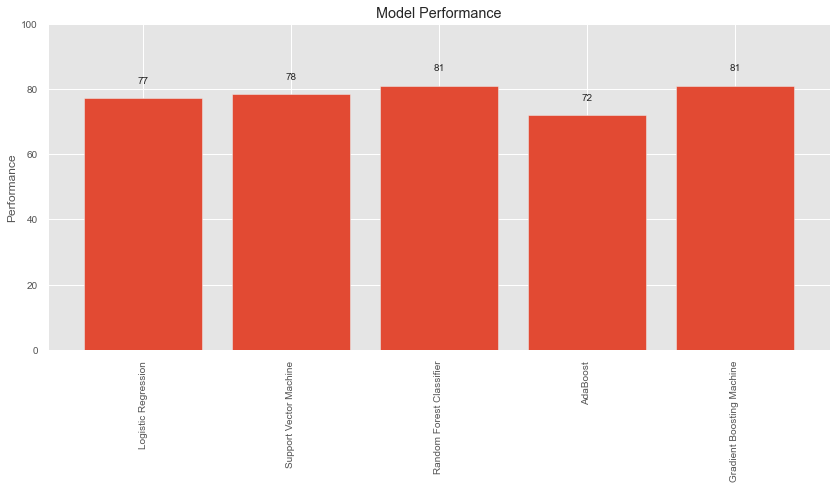

In [50]:
# tabular performance 
overall_res['Validation'] = overall_res['Validation']*100
overall_res['Best_test_score'] = overall_res['Best_test_score']*100
overall_res

# visualization of performances
fig, ax = plt.subplots( figsize = (14,6))


barr = plt.bar(range(5),overall_res['Validation'])
plt.xticks(range(5), overall_res.Classifier, rotation = 90)
plt.title('Model Performance')
plt.ylabel('Performance')
plt.ylim((0,100))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    counter = 0
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(overall_res['Validation'].iloc[counter]),
                ha='center', va='bottom')
        counter+=1
        
autolabel(barr)
        
plt.show()

The best performers are LogisticRegression, SVM and RandomForestClassifier. For the sake of simplicity, I will use the LogisticRegression as the final model to train. 

## Final Model and submission

In [51]:
# prepare the dataset for the classifier 
X, y = train.iloc[:,1:], train.iloc[:,0]
df = train


# applying feature selection
to_drop_log = ['name_words_count', 'has_brakets', 'ticket_letter', 'log_fare_below_2', 'independent', 
           'embarked_opt_Q', 'embarked_opt_S', 'cabin_key_B', 'cabin_key_C', 
           'cabin_key_D', 'cabin_key_E', 'cabin_key_F', 'cabin_key_G', 'salutation_Dr', 
           'salutation_Miss', 'salutation_Mr', 'salutation_Ms']

X.drop(to_drop_log, axis = 1, inplace = True)
test.drop(to_drop_log, axis = 1, inplace = True)

#Model performance evaluation with feature selected
pipe = Pipeline([('sc', sc), ('classifier', log)])

predictions = pipe.fit(X, y).predict(test)

print(predictions[:10])


[0 1 0 0 1 0 1 0 1 0]


In [52]:
ids = test.index
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions.astype(int)})
output.to_csv('submission.csv', index=False)

This model lead to a score of 0.779 on Kaggle, position 7k+ on the leaderboard